In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\137350966.py:7: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31

In [32]:
class SensorGRUD(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SensorGRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU-D cell
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Decay parameters
        self.gamma_x = nn.Parameter(torch.ones(input_size))
        self.gamma_h = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, mask=None, delta=None):
        # x: (batch, seq_len, input_size)
        # mask: (batch, seq_len, input_size) - 1 if observed, 0 if missing
        # delta: (batch, seq_len, input_size) - time since last observation

        if mask is not None and delta is not None:
            # Apply decay to missing values
            gamma_x = torch.exp(-torch.relu(self.gamma_x) * delta)
            x = mask * x + (1 - mask) * gamma_x * x

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [33]:
class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dense_size=64, output_size=1, dropout=0.2):
        super(GRUPredictor, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1,
                           batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2,
                           batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.gru1(x)         # (batch, seq_len, hidden1)
        out = self.dropout(out)
        out, _ = self.gru2(out)       # (batch, seq_len, hidden2)
        out = out[:, -1, :]           # Lấy output tại bước thời gian cuối (batch, hidden2)
        out = self.fc1(out)           # (batch, dense)
        out = self.relu(out)
        out = self.fc2(out)           # (batch, output_size)
        return out

In [34]:
device = torch.device("cuda")
sensor_model = SensorGRUD().to(device)
sensor_model.load_state_dict(torch.load("sensor_predictor_grud.pth", map_location=device))
sensor_model.eval()

resource_model = GRUPredictor(input_size=7).to(device)
resource_model.load_state_dict(torch.load("resource_predictor_gru.pth", map_location=device))
resource_model.eval()


GRUPredictor(
  (gru1): GRU(7, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (gru2): GRU(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [46]:
def load_and_scale_data(df, features):
    data = df[features].copy()
    data = data.interpolate(method='linear')
    data = data.fillna(method='bfill').fillna(method='ffill')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)
    return pd.DataFrame(scaled, columns=features), scaler

def create_lstm_dataset(df, input_seq_len=288, predict_len=288):
    X = []
    for i in range(len(df) - input_seq_len - predict_len):
        x_seq = df.iloc[i:i+input_seq_len].values
        X.append(x_seq)
    return np.array(X)

def reshape_for_sensor_model(X):  # (B, T, F) → (B * F, T, 1)
    B, T, F = X.shape
    X = X.transpose(0, 2, 1).reshape(-1, T, 1)
    return torch.tensor(X, dtype=torch.float32)

In [47]:
def run_prediction_pipeline_batched(df, features, batch_size=64):
    df_scaled, _ = load_and_scale_data(df, features)
    X = create_lstm_dataset(df_scaled, 288, 288)
    B, T, F = X.shape

    # Reshape to (B * F, T, 1)
    X_sensor = reshape_for_sensor_model(X)  # Tensor (B*F, T, 1)
    dataset = TensorDataset(X_sensor)
    loader = DataLoader(dataset, batch_size=batch_size)

    sensor_model.to(device).eval()
    resource_model.to(device).eval()

    sensor_outputs = []

    with torch.no_grad():
        for batch in loader:
            xb = batch[0].to(device)
            out = sensor_model(xb)  # (batch_size, 1)
            sensor_outputs.append(out.cpu())

    sensor_outputs = torch.cat(sensor_outputs, dim=0)  # (B * F, 1)

    # Reshape to (B, F, 1)
    sensor_outputs = sensor_outputs.view(B, F, 1)
    resource_input = sensor_outputs.permute(0, 2, 1).to(device)  # (B, 1, F)

    with torch.no_grad():
        prediction = resource_model(resource_input)  # (B, 1)

    return prediction.cpu()

In [ ]:
torch.cuda.empty_cache()
features = ["BlackScr", "PipeGrow", "PipeLow", "Tot_PAR", "VentLee", "Ventwind", "t_heat_sp"]
df = ds["Digilog"]["GreenhouseClimate.csv"]
preds = run_prediction_pipeline_batched(df, features)
print(preds.shape)  # (B, 1)
print(preds[:5])   






C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\1464821732.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='bfill').fillna(method='ffill')


torch.Size([47233, 1])
tensor([[0.1760],
        [0.1759],
        [0.1758],
        [0.1757],
        [0.1756]])


C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\1530743960.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\1530743960.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\1530743960.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series.fillna(method='bfill').fillna(method='ffill')
C:\Users\thanh\AppData\Local\Temp\ipykernel_19524\1530743960.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() i

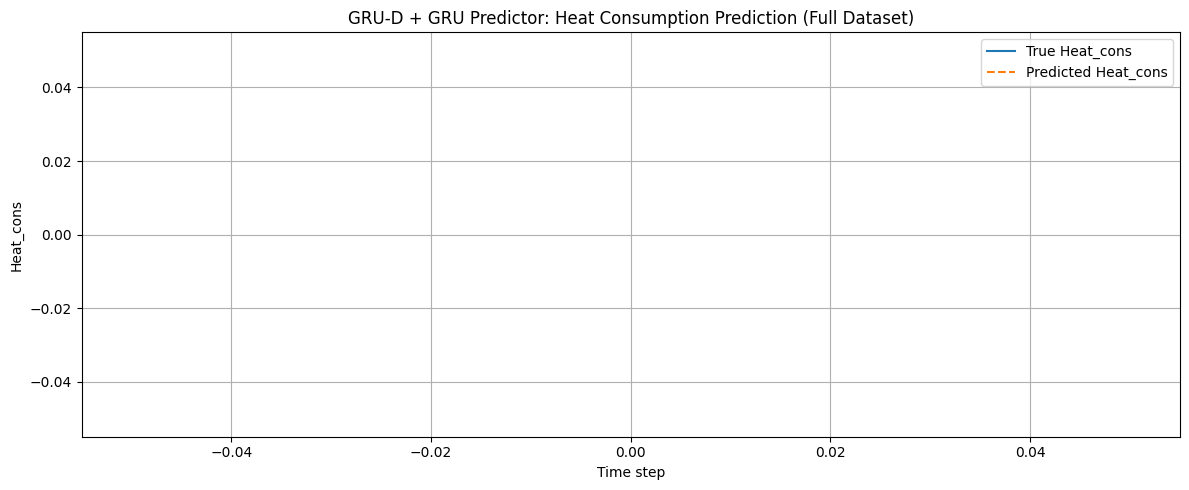

In [62]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ==== 1. Mô hình ====
df_X = ds["Digilog"]["GreenhouseClimate.csv"]
df_Y = ds["Digilog"]["Resources.csv"]
class SensorGRUD(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SensorGRUD, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.gamma_x = nn.Parameter(torch.ones(input_size))
        self.gamma_h = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, mask=None, delta=None):
        if mask is not None and delta is not None:
            gamma_x = torch.exp(-torch.relu(self.gamma_x) * delta)
            x = mask * x + (1 - mask) * gamma_x * x
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dense_size=64, output_size=1, dropout=0.2):
        super(GRUPredictor, self).__init__()
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.gru2 = nn.GRU(input_size=hidden_size1, hidden_size=hidden_size2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_size, output_size)

    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.dropout(out)
        out, _ = self.gru2(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ==== 2. Xử lý dữ liệu ====

def load_and_scale_data(df, feature):
    series = df[[feature]].copy()
    series = series.interpolate(method='linear')
    series = series.fillna(method='bfill').fillna(method='ffill')
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(series)
    return pd.DataFrame(scaled, columns=[feature]), scaler

def create_lstm_dataset(df, input_seq_len=288):
    X = []
    for i in range(len(df) - input_seq_len):
        x_seq = df.iloc[i:i + input_seq_len].values
        X.append(x_seq)
    return np.array(X)  # (num_seq, seq_len, 1)

# ==== 3. Thiết lập ====

features_X = ["BlackScr", "PipeGrow", "PipeLow", "Tot_PAR", "VentLee", "Ventwind", "t_heat_sp"]
feature_Y = "Heat_cons"
input_seq_len = 288

# Giả sử đã có df_X và df_Y
# df_X = ds["Digilog"]["GreenhouseClimate.csv"]
# df_Y = ds["Digilog"]["Resources.csv"]

# ==== 4. Load models ====

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sensor_grud = SensorGRUD(input_size=1).to(device)
sensor_grud.load_state_dict(torch.load("sensor_predictor_grud.pth", map_location=device))
sensor_grud.eval()

gru_predictor = GRUPredictor(input_size=len(features_X)).to(device)
gru_predictor.load_state_dict(torch.load("resource_predictor_gru.pth", map_location=device))
gru_predictor.eval()

# ==== 5. Chạy SensorGRUD cho từng feature ====

output_grud_all = []

for feature in features_X:
    df_feat_scaled, scaler_feat = load_and_scale_data(df_X, feature)
    X_seq = create_lstm_dataset(df_feat_scaled, input_seq_len=input_seq_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)  # (B, seq_len, 1)

    preds = []
    with torch.no_grad():
        for x in X_tensor:
            x = x.unsqueeze(0)  # (1, seq_len, 1)
            pred = sensor_grud(x)  # (1, 1)
            preds.append(pred.squeeze(1))

    preds = torch.cat(preds, dim=0).unsqueeze(1)  # (B, 1)
    output_grud_all.append(preds)

# Stack lại thành (B, 1, F)
gru_input = torch.cat(output_grud_all, dim=1).unsqueeze(1)  # (B, 1, F)

# ==== 6. Dự đoán Heat_cons ====

with torch.no_grad():
    pred_Y = gru_predictor(gru_input)  # (B, 1)

# ==== 7. Chuẩn hóa Ground Truth Y ====

df_Y_clean = df_Y[[feature_Y]].copy()
df_Y_clean = df_Y_clean.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(df_Y_clean)

# Căn chỉnh chiều (bỏ 288 bước đầu), đồng bộ chiều
y_true_all = Y_scaled[input_seq_len:]
pred_Y_inv = scaler_Y.inverse_transform(pred_Y.cpu().numpy())

min_len = min(len(y_true_all), len(pred_Y_inv))
Y_seq = y_true_all[:min_len]
pred_Y_inv = pred_Y_inv[:min_len]

# ==== 8. Metrics đánh giá ====
# mse = mean_squared_error(Y_seq, pred_Y_inv)
# mae = mean_absolute_error(Y_seq, pred_Y_inv)
# r2 = r2_score(Y_seq, pred_Y_inv)

# print(f"\n🎯 Evaluation on 100% dataset (after warmup {input_seq_len} steps):")
# print(f"🔹 MSE  = {mse:.4f}")
# print(f"🔹 MAE  = {mae:.4f}")
# print(f"🔹 R²   = {r2:.4f}\n")

# ==== 9. Trực quan hóa ====
plt.figure(figsize=(12, 5))
plt.plot(Y_seq, label="True Heat_cons")
plt.plot(pred_Y_inv, label="Predicted Heat_cons", linestyle="--")
plt.title("GRU-D + GRU Predictor: Heat Consumption Prediction (Full Dataset)")
plt.xlabel("Time step")
plt.ylabel("Heat_cons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
